<a href="https://colab.research.google.com/github/Alisha-suresh/DISSERTATION-COMBINE/blob/NEWBLOCKCHAIN/src/centralized/fake_news_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import joblib
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [3]:
# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to tokenize text in batches
def tokenize_text_in_batches(texts, batch_size=128):
    num_batches = int(np.ceil(len(texts) / batch_size))
    tokenized_batches = []

    print(f"Tokenizing data in {num_batches} batches...", flush=True)

    for i in range(num_batches):
        batch_texts = texts[i * batch_size:(i + 1) * batch_size]
        tokenized_batch = tokenizer(
            batch_texts.tolist(),
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        tokenized_batches.append(tokenized_batch)
        print(f"Batch {i+1}/{num_batches} tokenized.", flush=True)

    print("Tokenization complete.", flush=True)
    return tokenized_batches


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [4]:
# Apply PCA to reduce dimensionality in batches
def apply_pca_in_batches(tokenized_batches, pca_components=100):
    pca = PCA(n_components=pca_components)
    X_pca_batches = []

    print(f"Applying PCA in {len(tokenized_batches)} batches...", flush=True)

    for i, tokenized_batch in enumerate(tokenized_batches):
        pca_batch = pca.fit_transform(tokenized_batch['input_ids'].numpy()) if i == 0 else pca.transform(tokenized_batch['input_ids'].numpy())
        X_pca_batches.append(pca_batch)
        print(f"PCA applied to batch {i+1}/{len(tokenized_batches)}.", flush=True)

    print("PCA complete.", flush=True)
    return X_pca_batches

In [5]:
# Read and process the dataset in batches
def load_and_preprocess_data_in_batches(file_path, chunksize=10000, pca_components=100):
    X_pca_all = []
    y_all = []
    total_batches = 0

    print("Loading and preprocessing data in batches...", flush=True)

    # Read in chunks
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        print(f"Processing chunk {total_batches+1}...", flush=True)
        print(f"Number of records in chunk {total_batches+1}: {len(chunk)}", flush=True)

        X_chunk = chunk['text']
        y_chunk = chunk['labels']

        # Tokenize the current chunk
        X_tokenized_batches = tokenize_text_in_batches(X_chunk, batch_size=chunksize)

        # Apply PCA in batches
        X_pca_batches = apply_pca_in_batches(X_tokenized_batches, pca_components)

        # Flatten batches and store them
        X_pca_all.append(np.vstack(X_pca_batches))
        y_all.append(y_chunk.values)

        total_batches += 1
        print(f"Chunk {total_batches} processed.", flush=True)

    # Combine all processed chunks
    X_pca_all = np.vstack(X_pca_all)
    y_all = np.concatenate(y_all)

    print("Data loading and preprocessing complete.", flush=True)
    return X_pca_all, y_all

In [7]:
# Load and preprocess the data
file_path = "combined_dataset.csv"  # Adjust the path as needed
print(f"Reading the dataset from {file_path}...", flush=True)
raw_data = pd.read_csv(file_path)
print(f"Initial number of records: {len(raw_data)}", flush=True)
X_pca, y = load_and_preprocess_data_in_batches(file_path, chunksize=10000, pca_components=100)

print(f"Processed data shape: {X_pca.shape}, Labels shape: {y.shape}", flush=True)

Reading the dataset from combined_dataset.csv...
Initial number of records: 51329
Loading and preprocessing data in batches...
Processing chunk 1...
Number of records in chunk 1: 10000
Tokenizing data in 1 batches...
Batch 1/1 tokenized.
Tokenization complete.
Applying PCA in 1 batches...
PCA applied to batch 1/1.
PCA complete.
Chunk 1 processed.
Processing chunk 2...
Number of records in chunk 2: 10000
Tokenizing data in 1 batches...
Batch 1/1 tokenized.
Tokenization complete.
Applying PCA in 1 batches...
PCA applied to batch 1/1.
PCA complete.
Chunk 2 processed.
Processing chunk 3...
Number of records in chunk 3: 10000
Tokenizing data in 1 batches...
Batch 1/1 tokenized.
Tokenization complete.
Applying PCA in 1 batches...
PCA applied to batch 1/1.
PCA complete.
Chunk 3 processed.
Processing chunk 4...
Number of records in chunk 4: 10000
Tokenizing data in 1 batches...
Batch 1/1 tokenized.
Tokenization complete.
Applying PCA in 1 batches...
PCA applied to batch 1/1.
PCA complete.
Chun

In [8]:
print(raw_data.columns)

Index(['text', 'title', 'labels'], dtype='object')


In [9]:
import xgboost as xgb
print(xgb.__version__)



2.1.1


In [10]:
# Handling class imbalance by computing class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# 1. Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

def convert_to_1d_labels(y):
    print(f"Original y shape: {y.shape}", flush=True)
    print(f"Original y type: {type(y)}", flush=True)

    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y = y.values

    if y.ndim > 1:
        if y.shape[1] == 1:
            y = y.ravel()
        elif y.shape[1] == 2:
            # Assuming binary classification with one-hot encoding
            y = y.argmax(axis=1)
        else:
            y = np.argmax(y, axis=1)

    print(f"Converted y shape: {y.shape}", flush=True)
    print(f"Converted y type: {type(y)}", flush=True)
    return y

y_train_1d = convert_to_1d_labels(y_train)
print(f"y_train_1d shape after conversion: {y_train_1d.shape}")

# Cross-validation setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def cross_val_evaluate_model(model, X, y, model_name, cv=kf):
    print(f"Starting cross-validation for {model_name}", flush=True)
    print(f"X shape: {X.shape}, y shape: {y.shape}", flush=True)

    accuracy_scores, f1_scores, precision_scores, recall_scores, roc_auc_scores = [], [], [], [], []

    for fold, (train_index, val_index) in enumerate(cv.split(X, y), 1):
        print(f"Fold {fold}:", flush=True)
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        print(f"  X_train shape: {X_train_fold.shape}, y_train shape: {y_train_fold.shape}", flush=True)
        print(f"  X_val shape: {X_val_fold.shape}, y_val shape: {y_val_fold.shape}", flush=True)

        try:
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)

            accuracy_scores.append(accuracy_score(y_val_fold, y_pred))
            f1_scores.append(f1_score(y_val_fold, y_pred, average='weighted'))
            precision_scores.append(precision_score(y_val_fold, y_pred, average='weighted'))
            recall_scores.append(recall_score(y_val_fold, y_pred, average='weighted'))

            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_val_fold)
                # Use only the probability of the positive class (second column)
                roc_auc_scores.append(roc_auc_score(y_val_fold, y_pred_proba[:, 1]))
            else:
                y_decision = model.decision_function(X_val_fold)
                roc_auc_scores.append(roc_auc_score(y_val_fold, y_decision))

            print(f"  Fold {fold} completed successfully", flush=True)
        except Exception as e:
            print(f"  Error in fold {fold}: {str(e)}", flush=True)
            raise

    print(f"{model_name} Cross-Validation Complete", flush=True)
    print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}", flush=True)
    print(f"Average F1-Score: {np.mean(f1_scores):.4f}", flush=True)
    print(f"Average Precision Score: {np.mean(precision_scores):.4f}", flush=True)
    print(f"Average ROC-AUC Score: {np.mean(roc_auc_scores):.4f}", flush=True)
    print(f"Average Recall Score: {np.mean(recall_scores):.4f}", flush=True)
    return np.mean(accuracy_scores), np.mean(f1_scores), np.mean(roc_auc_scores), np.mean(recall_scores), np.mean(precision_scores)
    return model

Original y shape: (41063,)
Original y type: <class 'numpy.ndarray'>
Converted y shape: (41063,)
Converted y type: <class 'numpy.ndarray'>
y_train_1d shape after conversion: (41063,)


In [12]:

# Example hyperparameter grids
logreg_param_grid = {'C': [0.01, 0.1, 1, 10]}
rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}
xgb_param_grid = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.3]}

# Function for hyperparameter tuning using GridSearchCV or RandomizedSearchCV
def tune_model_hyperparameters(model, param_grid, X, y, search_type='grid'):
    print(f"Tuning hyperparameters for {model.__class__.__name__} using {search_type} search...", flush=True)
    if search_type == 'grid':
        search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
    else:
        search = RandomizedSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, n_iter=10)

    search.fit(X, y)
    print(f"Best Parameters for {model.__class__.__name__}: {search.best_params_}", flush=True)
    return search.best_estimator_




In [13]:
# Tune models on the training set
logreg_tuned = tune_model_hyperparameters(LogisticRegression(class_weight='balanced', max_iter=1000), logreg_param_grid, X_train, y_train, search_type='grid')
rf_tuned = tune_model_hyperparameters(RandomForestClassifier(class_weight='balanced', random_state=42), rf_param_grid, X_train, y_train, search_type='grid')
xgb_tuned = tune_model_hyperparameters(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), xgb_param_grid, X_train, y_train, search_type='random')

# Convert y_train to 1D before final evaluation
y_train_1d = convert_to_1d_labels(y_train)

print(f"Final y_train_1d shape: {y_train_1d.shape}", flush=True)
print(f"Final y_train_1d type: {type(y_train_1d)}", flush=True)

# Final evaluation on the tuned models
logreg_results = cross_val_evaluate_model(logreg_tuned, X_train, y_train_1d, "Tuned Logistic Regression")
print(f"Tuned Logistic Regression Complete: Accuracy={logreg_results[0]:.4f}, F1-Score={logreg_results[1]:.4f}, Precision={logreg_results[4]:.4f}, Recall={logreg_results[3]:.4f}, ROC-AUC={logreg_results[2]:.4f}\n", flush=True)

rf_results = cross_val_evaluate_model(rf_tuned, X_train, y_train_1d, "Tuned Random Forest")
print(f"Tuned Random Forest Complete: Accuracy={rf_results[0]:.4f}, F1-Score={rf_results[1]:.4f}, Precision={rf_results[4]:.4f}, Recall={rf_results[3]:.4f}, ROC-AUC={rf_results[2]:.4f}\n", flush=True)

xgb_results = cross_val_evaluate_model(xgb_tuned, X_train, y_train_1d, "Tuned XGBoost")
print(f"Tuned XGBoost Complete: Accuracy={xgb_results[0]:.4f}, F1-Score={xgb_results[1]:.4f}, ROC-AUC={xgb_results[2]:.4f}, Precision={xgb_results[4]:.4f}, Recall={xgb_results[3]:.4f}\n", flush=True)



Tuning hyperparameters for LogisticRegression using grid search...
Best Parameters for LogisticRegression: {'C': 0.01}
Tuning hyperparameters for RandomForestClassifier using grid search...
Best Parameters for RandomForestClassifier: {'max_depth': 20, 'n_estimators': 300}
Tuning hyperparameters for XGBClassifier using random search...
Best Parameters for XGBClassifier: {'n_estimators': 300, 'learning_rate': 0.1}
Original y shape: (41063,)
Original y type: <class 'numpy.ndarray'>
Converted y shape: (41063,)
Converted y type: <class 'numpy.ndarray'>
Final y_train_1d shape: (41063,)
Final y_train_1d type: <class 'numpy.ndarray'>
Starting cross-validation for Tuned Logistic Regression
X shape: (41063, 100), y shape: (41063,)
Fold 1:
  X_train shape: (32850, 100), y_train shape: (32850,)
  X_val shape: (8213, 100), y_val shape: (8213,)
  Fold 1 completed successfully
Fold 2:
  X_train shape: (32850, 100), y_train shape: (32850,)
  X_val shape: (8213, 100), y_val shape: (8213,)
  Fold 2 comp

In [14]:
# Stacking Ensemble Model
estimators = [
    ('logreg', logreg_tuned),
    ('rf', rf_tuned),
    ('xgb', xgb_tuned)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_results = cross_val_evaluate_model(stacking_model, X_train, y_train_1d, "Stacking Ensemble")

# Selection based on F1-score, Precision Accuracy, and ROC-AUC
model_performance = {
    'Logistic Regression': logreg_results,
    'Random Forest': rf_results,
    'XGBoost': xgb_results,
    'Stacking Ensemble': stacking_results
}

# Choose the model with the highest F1-Score, ROC-AUC, and Accuracy
best_model_name = max(model_performance, key=lambda k: (model_performance[k][3], model_performance[k][4], model_performance[k][0]))
best_model = {
    'Logistic Regression': logreg_tuned,
    'Random Forest': rf_tuned,
    'XGBoost': xgb_tuned,
    'Stacking Ensemble': stacking_model
}[best_model_name]

print(f"Best model selected: {best_model_name} with F1-Score: {model_performance[best_model_name][3]:.4f}, ROC-AUC: {model_performance[best_model_name][4]:.4f}, Accuracy: {model_performance[best_model_name][0]:.4f}", flush=True)

Starting cross-validation for Stacking Ensemble
X shape: (41063, 100), y shape: (41063,)
Fold 1:
  X_train shape: (32850, 100), y_train shape: (32850,)
  X_val shape: (8213, 100), y_val shape: (8213,)
  Fold 1 completed successfully
Fold 2:
  X_train shape: (32850, 100), y_train shape: (32850,)
  X_val shape: (8213, 100), y_val shape: (8213,)
  Fold 2 completed successfully
Fold 3:
  X_train shape: (32850, 100), y_train shape: (32850,)
  X_val shape: (8213, 100), y_val shape: (8213,)
  Fold 3 completed successfully
Fold 4:
  X_train shape: (32851, 100), y_train shape: (32851,)
  X_val shape: (8212, 100), y_val shape: (8212,)
  Fold 4 completed successfully
Fold 5:
  X_train shape: (32851, 100), y_train shape: (32851,)
  X_val shape: (8212, 100), y_val shape: (8212,)
  Fold 5 completed successfully
Stacking Ensemble Cross-Validation Complete
Average Accuracy: 0.8335
Average F1-Score: 0.8327
Average Precision Score: 0.8332
Average ROC-AUC Score: 0.9010
Average Recall Score: 0.8335
Best m

In [15]:
# Convert y_test to 1D array
y_test_1d = convert_to_1d_labels(y_test)

# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test_1d, y_pred_best)
test_f1 = f1_score(y_test_1d, y_pred_best, average='weighted')
test_precision = precision_score(y_test_1d, y_pred_best, average='weighted')
test_recall = recall_score(y_test_1d, y_pred_best, average='weighted')

if hasattr(best_model, 'predict_proba'):
    y_pred_proba = best_model.predict_proba(X_test)
    # Check if it's binary classification
    if y_pred_proba.shape[1] == 2:
        # Use the probability of the positive class (second column)
        test_roc_auc = roc_auc_score(y_test_1d, y_pred_proba[:, 1])
    else:
        # For multi-class, use 'ovr' (one-vs-rest) approach
        test_roc_auc = roc_auc_score(y_test_1d, y_pred_proba, multi_class='ovr', average='weighted')
else:
    test_roc_auc = roc_auc_score(y_test_1d, best_model.decision_function(X_test), multi_class='ovr', average='weighted')

print(f"Test Set Evaluation for {best_model_name} - Accuracy: {test_accuracy:.4f}, F1-Score: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, ROC-AUC: {test_roc_auc:.4f}")


Original y shape: (10266,)
Original y type: <class 'numpy.ndarray'>
Converted y shape: (10266,)
Converted y type: <class 'numpy.ndarray'>
Test Set Evaluation for Stacking Ensemble - Accuracy: 0.8263, F1-Score: 0.8256, Precision: 0.8258, Recall: 0.8263, ROC-AUC: 0.8949


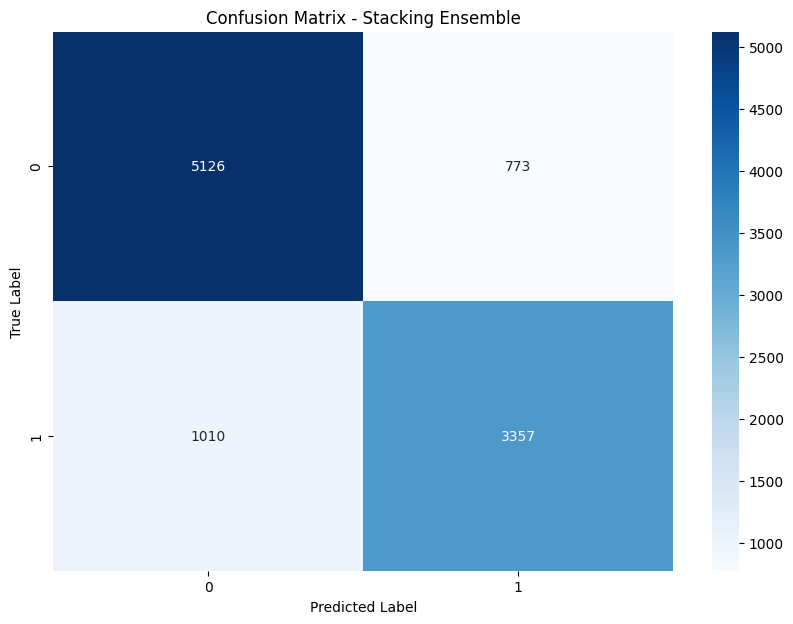

In [16]:
# Show confusion matrix for the best model on the test set
cm = confusion_matrix(y_test_1d, y_pred_best)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [17]:
# # Save the best model

import json
model_save_dir = 'best_fake_news_model'
os.makedirs(model_save_dir, exist_ok=True)

# Save the original model (you might want to keep this for reference)
model_save_path = os.path.join(model_save_dir, f'{best_model_name.lower().replace(" ", "_")}_model.bin')
joblib.dump(best_model, model_save_path)
print(f"{best_model_name} model saved to {model_save_path}")

# Save the model parameters
params_save_path = os.path.join(model_save_dir, f'{best_model_name.lower().replace(" ", "_")}_params.json')
model_params = best_model.get_params()

# Convert non-serializable objects to strings
serializable_params = {}
for key, value in model_params.items():
    if isinstance(value, (int, float, str, bool, type(None))):
        serializable_params[key] = value
    else:
        serializable_params[key] = str(value)

with open(params_save_path, 'w') as f:
    json.dump(serializable_params, f)
print(f"Model parameters saved to {params_save_path}")

# Save feature importances (if applicable)
if hasattr(best_model, 'feature_importances_'):
    importances_save_path = os.path.join(model_save_dir, f'{best_model_name.lower().replace(" ", "_")}_feature_importances.npy')
    np.save(importances_save_path, best_model.feature_importances_)
    print(f"Feature importances saved to {importances_save_path}")

# Save the model structure
structure_save_path = os.path.join(model_save_dir, f'{best_model_name.lower().replace(" ", "_")}_structure.json')
model_structure = {
    'n_estimators': best_model.n_estimators_ if hasattr(best_model, 'n_estimators_') else None,
    'n_features': best_model.n_features_in_ if hasattr(best_model, 'n_features_in_') else None,
    'n_classes': best_model.n_classes_ if hasattr(best_model, 'n_classes_') else None,
}
with open(structure_save_path, 'w') as f:
    json.dump(model_structure, f)
print(f"Model structure saved to {structure_save_path}")


Stacking Ensemble model saved to best_fake_news_model/stacking_ensemble_model.bin
Model parameters saved to best_fake_news_model/stacking_ensemble_params.json
Model structure saved to best_fake_news_model/stacking_ensemble_structure.json


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 22.4 MB/s eta 0:00:00
Calculating feature importance using SHAP for Stacking Ensemble...


  0%|          | 0/1000 [00:00<?, ?it/s]

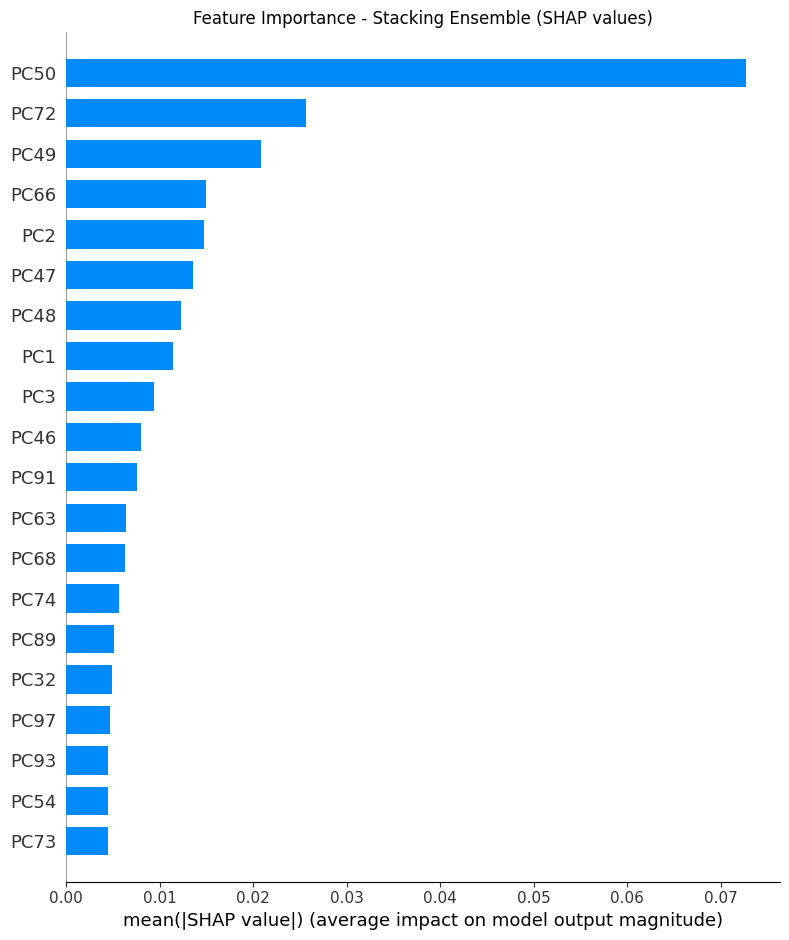

Feature ranking:
1. PC50 (0.0727)
2. PC72 (0.0256)
3. PC49 (0.0208)
4. PC66 (0.0150)
5. PC2 (0.0148)
6. PC47 (0.0136)
7. PC48 (0.0123)
8. PC1 (0.0114)
9. PC3 (0.0094)
10. PC46 (0.0080)
11. PC91 (0.0076)
12. PC63 (0.0064)
13. PC68 (0.0063)
14. PC74 (0.0057)
15. PC89 (0.0051)
16. PC32 (0.0049)
17. PC97 (0.0047)
18. PC93 (0.0045)
19. PC54 (0.0045)
20. PC73 (0.0044)
21. PC4 (0.0042)
22. PC5 (0.0041)
23. PC56 (0.0041)
24. PC40 (0.0041)
25. PC7 (0.0040)
26. PC8 (0.0040)
27. PC86 (0.0039)
28. PC6 (0.0039)
29. PC43 (0.0038)
30. PC42 (0.0038)
31. PC81 (0.0038)
32. PC11 (0.0038)
33. PC99 (0.0037)
34. PC58 (0.0037)
35. PC85 (0.0037)
36. PC70 (0.0036)
37. PC79 (0.0036)
38. PC92 (0.0035)
39. PC41 (0.0035)
40. PC90 (0.0034)
41. PC60 (0.0034)
42. PC57 (0.0034)
43. PC88 (0.0033)
44. PC69 (0.0033)
45. PC71 (0.0033)
46. PC94 (0.0033)
47. PC87 (0.0032)
48. PC67 (0.0032)
49. PC33 (0.0032)
50. PC44 (0.0032)
51. PC98 (0.0032)
52. PC75 (0.0031)
53. PC100 (0.0031)
54. PC80 (0.0031)
55. PC77 (0.0031)
56. PC55 

In [19]:
%pip install shap
import shap
import matplotlib.pyplot as plt
import numpy as np

print("Calculating feature importance using SHAP for Stacking Ensemble...", flush=True)

# Assuming we have principal components after PCA
feature_names = [f'PC{i+1}' for i in range(X_train.shape[1])]

# Create a function that mimics the predict method of your model
def model_predict(X):
    return best_model.predict_proba(X)[:, 1]  # Assuming binary classification

# Create a SHAP explainer using the KernelExplainer
explainer = shap.KernelExplainer(model_predict, shap.sample(X_train, 100))  # Using a sample of 100 instances for speed

# Calculate SHAP values for a subset of the data
shap_values = explainer.shap_values(X_train[:1000])  # Using first 1000 instances for speed

# Plot feature importance
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train[:1000], plot_type="bar", feature_names=feature_names, show=False)
plt.title("Feature Importance - Stacking Ensemble (SHAP values)")
plt.tight_layout()
plt.show()

# Print feature importance ranking
feature_importance = np.abs(shap_values).mean(0)
feature_importance_sorted_idx = np.argsort(feature_importance)
print("Feature ranking:", flush=True)
for i in range(len(feature_importance_sorted_idx)):
    idx = feature_importance_sorted_idx[-(i+1)]
    print(f"{i+1}. {feature_names[idx]} ({feature_importance[idx]:.4f})", flush=True)

In [21]:
!zip -r best_fake_news_model.zip best_fake_news_model
from google.colab import files
files.download('best_fake_news_model.zip')


  adding: best_fake_news_model/ (stored 0%)
  adding: best_fake_news_model/stacking_ensemble_structure.json (deflated 18%)
  adding: best_fake_news_model/stacking_ensemble_model.bin (deflated 76%)
  adding: best_fake_news_model/stacking_ensemble_params.json (deflated 77%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>